# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 17 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 1311 

# Apartado 1: Clasificador de noticias

__Número de grupo: 10__

__Nombres de los estudiantes: Rubén Gómez, Adrián Sanjuán y Adrián Pérez__

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no debes usarlo para clasificar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías. Indica si debemos tenerlo en cuenta de alguna forma al analizar los modelos que construyamos.

Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [2]:
import numpy as np
import pandas as pd
df_news = pd.read_csv('BBC News.csv', index_col = 0)
df_news

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business
...,...,...
857,double eviction from big brother model caprice...,entertainment
325,dj double act revamp chart show dj duo jk and ...,entertainment
1590,weak dollar hits reuters revenues at media gro...,business


No handles with labels found to put in legend.


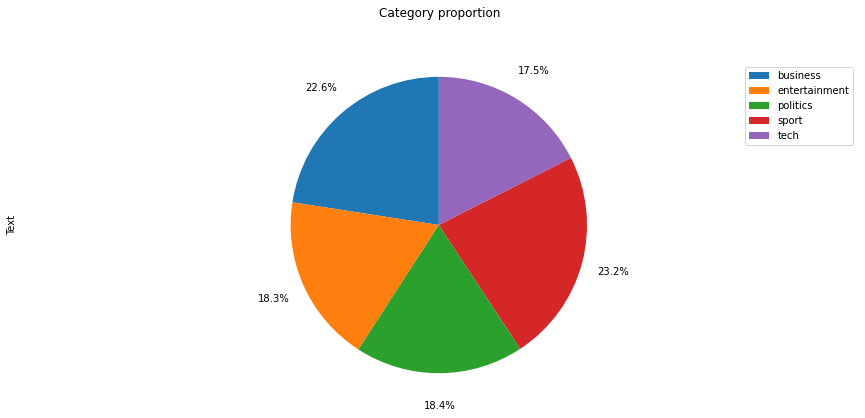

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
df_news.groupby("Category").count().plot.pie(autopct='%1.1f%%',
                 figsize=(15, 6),
                 startangle=90,      
                 labels=None,         
                 pctdistance=1.22,
                    subplots = True) 
plt.title('Category proportion', y=1.12) 
plt.axis('equal') 

plt.legend(labels=df_news.groupby("Category").count().index, loc='upper right') 

In [4]:
df_news.groupby("Category").count()

,Text
Category,
business,336
entertainment,273
politics,274
sport,346
tech,261


-----
Como podemos observar en la tabla anterior, si agrupamos por categorías el número de textos clasificados en cada categoría no difieren demasiado los unos con los otros. La máxima diferencia esta entre sport con 346 y tech con 261 y es de 85, por lo tanto las categorías están relativamente equilibradas. Que las categorías no estén exactamente proporcionadas no debería ser un problema ya que naive bayes tiene en cuenta la frecuencia de cada categoría y en cuanto al k-NN deberían estar suficientemente separadas en el espacio de dimensiones.

Quizás si hubiera una categoría con muy pocos textos, habría que tenerlo en cuenta a la hora del análisis ya que pocas instancias pueden desvirtuar la predicción dando mucha importancia a ciertas palabras cuando en realidad no son importantes.

In [232]:
print(df_news.iloc[45,0])
print(df_news.iloc[45,1])

#print(df_news.iloc(200,"Text"))

tv station refuses adoption show a tv station in the us has refused to show a controversial new series where adopted children try and pick their birth father - and win a cash prize.  the wraz-tv fox affiliate in north carolina was the only one of 182 stations to refuse monday s show. who s your daddy promises $100 000 (£52 000) to the contestant if she correctly identifies her father. it was met with protests by the national council for adoption  which said it  exploits  sensitive emotions.  it exploits the sensitive emotions of adoption   said thomas atwood  president of the national council for adoption.  it trivialises them. adoption is a very personal  meaningful experience and it should not be commercialised like this.  on the pre-taped programme  the contestant is presented with eight men who may or may not be her natural father.  if she picks the correct man from the line-up  the contestant wins the jackpot prize of us$100 000 (£52 590). however  if she picks the wrong man  then

----------------------------------------------------------
El texto se encuentra etiquetado como 'entertainment' porque trata sobre una serie/programa de un canal de televisión. Sin embargo creemos que quizás se podría confundir con uno de categoría 'politics' al hablar de temas como adopción y ética. Además se mencionan conceptos que se suelen asociar a la política como 'national council' o 'public protests' por lo que se ve que también es un texto que trata un tema político.

Pensamos que esta bien categorizado como 'entertainment' porque el tema principal del texto es un programa de televisión, pero si se etiquetara como 'politics' también estaría bien categorizado, consideramos que sería la segunda etiqueta más probable para el texto.

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_news, test_size = 0.2,random_state=RANDOM_STATE)
print(train.size)

2384


No handles with labels found to put in legend.


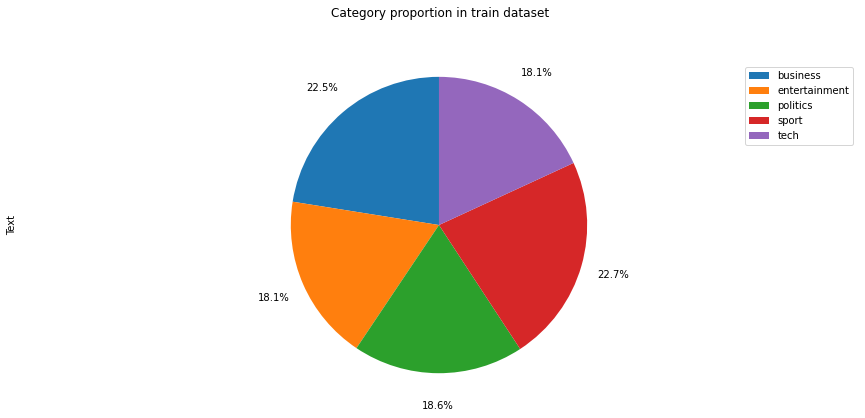

In [9]:
train.groupby("Category").count().plot.pie(autopct='%1.1f%%',
                 figsize=(15, 6),
                 startangle=90,      
                 labels=None,         
                 pctdistance=1.22,
                    subplots = True) 
plt.title('Category proportion in train dataset', y=1.12) 
plt.axis('equal') 

plt.legend(labels=train.groupby("Category").count().index, loc='upper right') 

Utilizamos la gráfica anterior para comprobar que el conjunto de entrenamiento está equilibrado en cuanto a número de instancias por categoría. Como vemos se ha obtenido un conjunto de entrenamiento incluso más equilibrado que el total.

## 2) Representación basada en bolsa de palabras y frecuencia de aparición

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y la frecuencia de aparición de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Entrena un clasificador Naive Bayes Multinomial y calcula su tasa de aciertos sobre el conjunto de entrenamiento y el conjunto de test. A continuación calcula los valores de precisión, exhaustividad y puntuación F1 para cada una de las clases. Dibuja la matriz de confusión. Analiza los resultados obtenidos.

A continuación, entrena un clasificador k-NN con la configuración por defecto y usando la misma vectorización. Analiza los resultados, ¿a qué crees que se deben?

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [11]:
vectorizer = CountVectorizer(stop_words='english', binary=False)
# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data_old=vectorizer.fit_transform(train.Text)

In [12]:
feature_names_old = vectorizer.get_feature_names()

print(len(feature_names_old))
#print(feature_names[:500])

22282


In [13]:
#print(train_vector_data_old[45])

In [14]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index][0])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [16]:
write_terms(feature_names_old, np.array(train), train_vector_data_old, 255)
write_terms(feature_names_old, np.array(train), train_vector_data_old, 100)

Mensaje 255 : hitachi unveils  fastest robot  japanese electronics firm hitachi has unveiled its first humanoid robot  called emiew  to challenge honda s asimo and sony s qrio robots.  hitachi said the 1.3m (4.2ft) emiew was the world s quickest-moving robot yet. two wheel-based emiews  pal and chum  introduced themselves to reporters at a press conference in japan. the robots will be guests at the world expo later this month. sony and honda have both built sophisticated robots to show off developments in electronics. explaining why hitachi s emiew used wheels instead of feet  toshihiko horiuchi  from hitachi s mechanical engineering research laboratory  said:  we aimed to create a robot that could live and co-exist with people.   we want to make the robots useful for people ... if the robots moved slower than people  users would be frustrated.  emiew - excellent mobility and interactive existence as workmate - can move at 3.7m/h. its  wheel feet  resemble the bottom half of a segway s

------------------
Podemos observar que hay algunos términos numéricos e incluso nombres propios que no tienen porque aportar gran significado al texto. Es posible que fechas, cantidades o incluso nombres propios conocidos de lugares o personas famosas nos puedan dar información o aportar significado a un texto para ayudar a clasificarlo pero hemos decidido considerar esto ruido ya que en la mayoría de casos pensamos que no aporta gran información. 

-----------------

Volvemos a realizar la vectorización, pero esta vez con un diccionario predeterminado de forma que el ruido mencionado anteriormente se elimina. Como efectos colaterales también es posible que se eliminen términos más específicos de las diferentes categorías del problema que con alta probabilidad no se encontrarán en un diccionario estándar y genérico como el que vamos a utilizar.

Otras opciones serían eliminar a mano el ruido o utilizar una herramienta más sofisitcada.

In [17]:
# Pasamos el fichero a una lista (una línea por item)
with open('words.txt') as f:
    dictionary = f.read().splitlines()

# El diccionario cargado lo pasamos en el parámetro vocabulary    
vectorizer = CountVectorizer(vocabulary=dictionary, stop_words='english')   

In [19]:
feature_names = vectorizer.get_feature_names()
print(len(feature_names))
#print(feature_names[:500])

466551


--------
Como vemos, hay más términos en nuestro vocabulario (466551 en vez de 22282) ya que en vez de utilizar solo los que aparecen en nuestro conjunto de entrenamiento, vamos a utilizar un diccionario predeterminado. Sin embargo, el número de términos en los diferentes textos vecotrizados será menor porque habrá muchas palabras o términos numéricos que al no aparecer en el diccionario no se consideren.

In [20]:
train_vector_data = vectorizer.fit_transform(train.Text)

#print(train_vector_data[12])

In [21]:
#Mostramos las dos vectorizaciones de un texto
write_terms(feature_names_old, np.array(train), train_vector_data_old, 100)
write_terms(feature_names, None, train_vector_data, 100)

Mensaje 100 : freeze on anti-spam campaign a campaign by lycos europe to target spam-related websites appears to have been put on hold.  earlier this week the company released a screensaver that bombarded the sites with data to try to bump up the running costs of the websites. but the site hosting the screensaver now displays a pink graphic and the words  stay tuned . no one at lycos was available for comment on latest developments in its controversial anti-spam campaign.  lycos europe s  make love not spam  campaign was intended as a way for users to fight back against the mountain of junk mail flooding inboxes. people were encouraged to download the screensaver which  when their pc was idle  would then send lots of data to sites that peddle the goods and services mentioned in spam messages. lycos said the idea was to get the spam sites running at 95% capacity and generate big bandwidth bills for the spammers behind the sites. but the plan has proved controversial.  monitoring firm ne

-------
En el bloque anterior se muestra el mismo mensaje con las dos vectorizaciones. 

La diferencia más evidente entre ambas es la ausencia de términos alfanuméricos como '1500m', '2005' y '800m' en la segunda vectorización realizada. Si indagamos observamos que también se han eliminado nombres propios como 'kelly'. Por tanto hemos logrado nuestro objetivo de eliminar el ruido, sin embargo, lo hemos hecho a costa de eliminar términos que si que podían ser útiles, como habíamos previsto. En la segunda vectorización desaparecen términos más específicos del tema tratado como 'olympic' o nombres propios de países como 'greece' o 'russia'.

In [22]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(test.Text)
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)
test_preprocessed = tfidfer.transform(test_vector_data)

#### Naive Bayes

In [23]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_preprocessed, train.Category)

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_test_predictions = mnb_classifier.predict(test_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == train.Category))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == test.Category))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9848993288590604
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9228187919463087


----
A priori, aunque es una métrica bastante básica, parece que funciona bastante ya que sobre el conjunto de test predice el 92.3% de las categorías de los textos bien. El porcentaje de acierto sobre el conjunto de entrenamiento obviamente es mayor ya que predice textos sobre los que ha entrenado y por eso es de prácticamente el 98.5%.

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
test.groupby("Category").count()

,Text
Category,
business,68
entertainment,57
politics,52
sport,76
tech,45


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'entertainment'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'tech')])

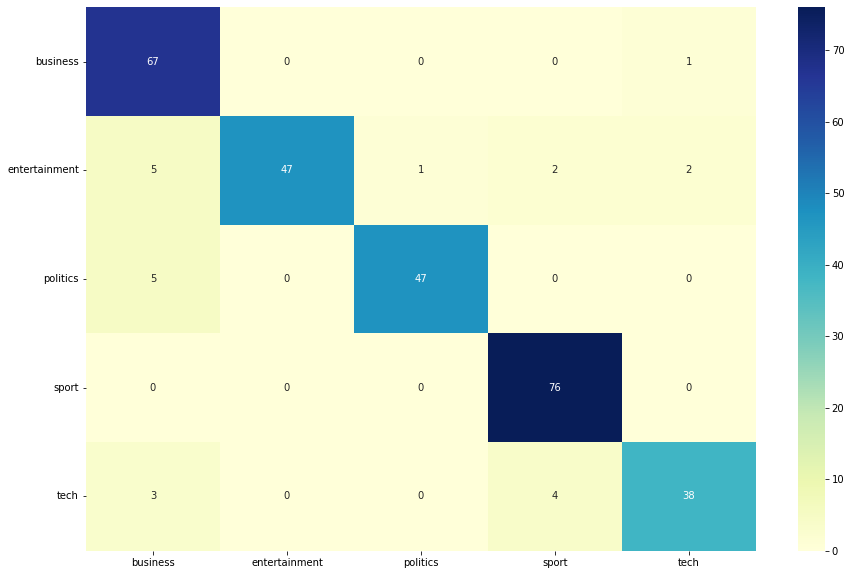

In [28]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

#Hemos consultado cuantas instancias hay de cada categoría en el conjunto de test para etiquetar correctamente
test_category_names=['business', 'entertainment', 'politics', 'sport', 'tech']

conf_matrix = confusion_matrix(test.Category, mnb_test_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_category_names, columns=test_category_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=0)


- FILAS: CATEGORÍA REAL
- COLUMNAS: PREDICCIONES



Una fila con muchos valores fuera de la diagonal, indica una exhaustividad/recall baja. Como vemos, los textos categorizados como 'entertainment' son los que más suele confundir el clasificador con otras categorías (sobre todo con business).

Una columna con muchos valores fuera de la diagonal indica una precisión baja. En la columna de la categoría 'business' se observa que pese a tener una exhaustividad/recall de casi 100% (es decir, predice casi todos los textos que pertenecen a esta categoría correctamente) también predice algunos falsos positivos con textos que en realidad pertencen a 'entertainment', 'politics' o 'tech'.

Fijándonos en la tabla se pueden apreciar relaciones entre los tipos de texto:
- Se puede ver que el único valor 0 en la columna de 'business' es el de la fila de 'sport', es decir, 'sport' es la única categoría que no se ha confundido en ningún caso con 'business'. Si tenemos en cuenta los posibles contenidos de estos textos se puede deducir que 'sport' es la categoría más "opuesta" a 'business' que puede haber.
- En la fila de 'entertainment' se puede ver que se confunde con todas las categorías. Tiene sentido ya que es un tema que puede hacer referencia a todas las demás categorías (desde tecnología si pensamos en tv o videojuegos por ejemplo, hasta deporte o política si pensamos en terulias televisivas).

In [29]:
print(classification_report(test.Category, mnb_test_predictions, target_names=test_category_names))

               precision    recall  f1-score   support

     business       0.84      0.99      0.91        68
entertainment       1.00      0.82      0.90        57
     politics       0.98      0.90      0.94        52
        sport       0.93      1.00      0.96        76
         tech       0.93      0.84      0.88        45

     accuracy                           0.92       298
    macro avg       0.93      0.91      0.92       298
 weighted avg       0.93      0.92      0.92       298



----
Lo observado anteriormente lo podemos apreciar en esta tabla. En general parece que el clasificador tiene una precisión especialmente baja a la hora de predecir textos de la categoría 'business' (única categoría por debajo de 0.93 con un valor de 0.84) lo que puede ser debido a que es una categoría muy general, que puede abordar otros temas, por lo que es relativamente fácil clasificar un texto de otra categoría como de business. En cuanto al recall, es especialmente bajo para 'entertainment' con un valor de 0.82, lo cual puede ser debido a que como consecuencia de lo expuesto anteriormente un texto se pueda llegar a clasificar de otra categoría cuando en realidad es de 'entertainment'.

El clasificador se comporta especialmente bien para la categoría 'sport' que tiene una precisión de 0.93 y un recall de 1.00. Como hemos observado en su relación con 'business' (se puede extrapolar también a otras como 'tech') quizás sea una de las categorías con menos relación con las demás y por ello no se confunde apenas.

#### k-NN

In [30]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_preprocessed, train.Category)

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train.Category))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == test.Category))

k-NN, porcentaje de aciertos en entrenamiento: 0.9546979865771812
k-NN, porcentaje de aciertos en test: 0.9060402684563759


----
El porcentaje de acierto del clasificador k-NN para el conjunto de test es de un 90.6% y de un 95.5% sobre el conjunto de entrenamiento. En general parece que tiene un porcentaje de acierto un poco menor (entre un 2% y un 3%) que el modelo anterior.

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'entertainment'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'tech')])

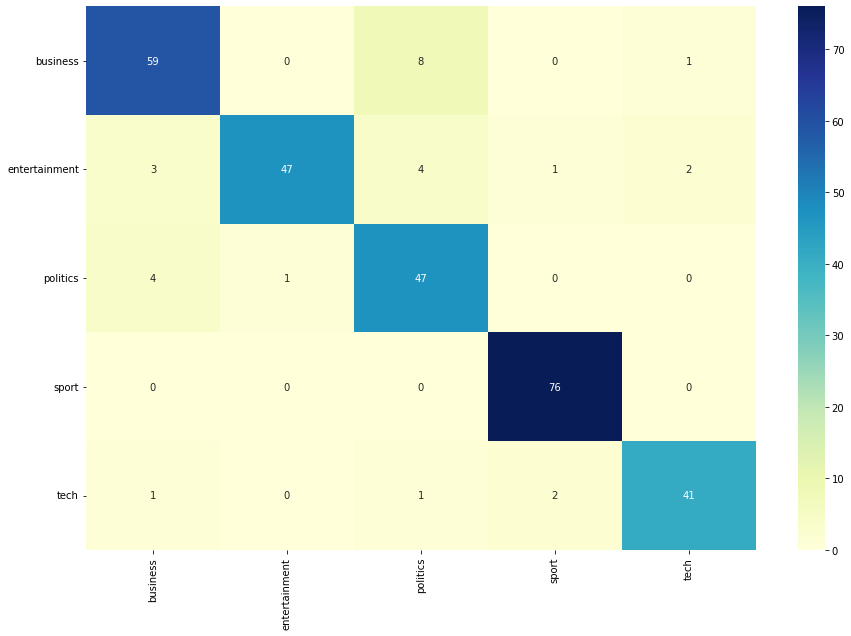

In [32]:
conf_matrix = confusion_matrix(test.Category, knn_test_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_category_names, columns=test_category_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [33]:
print(classification_report(test.Category, knn_test_predictions, target_names=test_category_names))

               precision    recall  f1-score   support

     business       0.88      0.87      0.87        68
entertainment       0.98      0.82      0.90        57
     politics       0.78      0.90      0.84        52
        sport       0.96      1.00      0.98        76
         tech       0.93      0.91      0.92        45

     accuracy                           0.91       298
    macro avg       0.91      0.90      0.90       298
 weighted avg       0.91      0.91      0.91       298



----
En media se observa que los valores son muy similares a los del clasificador naive bayes con una precisión un poco más baja y un recall ligeramente más alto lo que hace que tengan un f1-score prácticamente igual. Hay cuatro categorías con una precisión mayor que 0.93. En cuanto al recall no observamos ninguna categoría con un valor de 1 pero sin embargo todas tienen un valor por encima de 0.87. En general son clasificadores muy parecidos ya que el f1-score es muy similar para todas las categorías y en media es igual. La categoría 'sport' sigue teniendo los mejores valores para precisión y exhaustividad.

Como hemos visto en clase, un clasificador k-NN no es la mejor opción para esta clase de problemas ya que sufre de dimensionalidad buscando vecinos en un espacio de diimensiones muy grande. En este caso es muy acusado ya que hay menos instancias de entrenamiento (2384) que dimensiones tiene el problema (466551) por lo que no es lo más apropiado y los resultados puede que nos estén dando una 'falsa' sensación de que es un clasificador medianamente bueno.

Debido a las métricas analizadas y a la reflexión anterior, pensamos que el clasificador Naive Bayes Multinomial es más apropiado que el k-NN para este problema y este dataset.

## 3) Representación basada en word-embeddings

La segunda vectorización que vamos a usar representará los mensajes usando word-embeddings. Cada documento se representará como el vector que resulta de promediar los embeddings de cada una de sus palabras. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings. 

Entrena un clasificador Naive Bayes Gaussiano (el Multinomial no admite valores negativos que sí aparecen en los embeddings). Analiza el error por clase y dibuja la matriz de confusión.

Entrena otro clasificador kNN con la nueva vectorización y la configuración por defecto y analiza su error.

In [34]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

globe_file='glove.6B.50d.txt'
model = KeyedVectors.load_word2vec_format(globe_file, binary=False, no_header=True)

In [35]:
we_vocabulary = list(model.key_to_index.keys())
vectorizer = CountVectorizer(vocabulary = we_vocabulary, stop_words='english', binary = False)

In [36]:
tokens = vectorizer.get_feature_names()
print(len(tokens))

400000


In [37]:
train_vector_m = vectorizer.fit_transform(train.Text)
test_vector_m = vectorizer.transform(test.Text)

In [38]:
from scipy.sparse import find


def create_doc_embedding (doc_matrix_word_freq, keyedvectors):
    """
    create_doc_embedding creates a doc-embedding matrix where rows are the 
    documents and columns are the dimensions of the word-embedding. Each row r
    summarizes the vectors of the word-embeddings present in document r

    :param doc_matrix_word_freq: frequency matrix of the terms in each document
            It admits binary values, frequencies or weights.
            It admits the output of vectorizer.fit_transform
    :param keyedvectors: keyedvectors object from Gensim which has the 
            word-embedding information
    :return: returns the doc-embedding matrix that summarizes the 
             vector-embeddings of the words present in each document
    """ 

    
    num_docs, num_words= doc_matrix_word_freq.get_shape()

    # Creamos la matriz de documentos con tantas columnas como dimensiones tiene el we 
    doc_embed_matrix = np.zeros([num_docs,keyedvectors.vector_size])


    # Obtenemos los documentos
    docs, col, val = find(doc_matrix_word_freq)
    docs = np.unique(docs)

    # Para cada documento (esto se podrá hacer de forma más pythonica)
    for doc in docs:
      # Obtenemos las palabras presentes en el documento y su frecuencia
      row, words, frecs = find(doc_matrix_word_freq[doc,:])

      # Calculamos el vector medio para el documento
      # Para ello recuperamos los vectores del we presentes en el documento y 
      # los promediamos teniendo en cuenta su frecuencia
      count = 0
      for w,f in zip(words,frecs):
        doc_embed_matrix[doc,:] = doc_embed_matrix[doc,:] + (keyedvectors[w] * f)
        count = count +1
      doc_embed_matrix[doc,:] = doc_embed_matrix[doc,:]/count
    
      
    return doc_embed_matrix

In [39]:
doc_embed_matrix_train = create_doc_embedding(train_vector_m,model)
doc_embed_matrix_test = create_doc_embedding(test_vector_m,model)
# contiene un vector "embedding" para cada documento

#### Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(doc_embed_matrix_train, train.Category)

GaussianNB()

In [41]:
gnb_train_predictions = gnb_classifier.predict(doc_embed_matrix_train)
gnb_test_predictions = gnb_classifier.predict(doc_embed_matrix_test)

print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(gnb_train_predictions == train.Category))
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", np.mean(gnb_test_predictions == test.Category))

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9454697986577181
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.9194630872483222


El clasificador Naive Bayes Gaussiano con la vectorización mediante word-embeddings obtiene un porcentaje de acierto sobre el conjunto de entrenamiento del 94.5%, pero lo que más nos interesa que es el porcentaje de acierto con respecto al test es del 91.15%. Los valores son muy simila

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'entertainment'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'tech')])

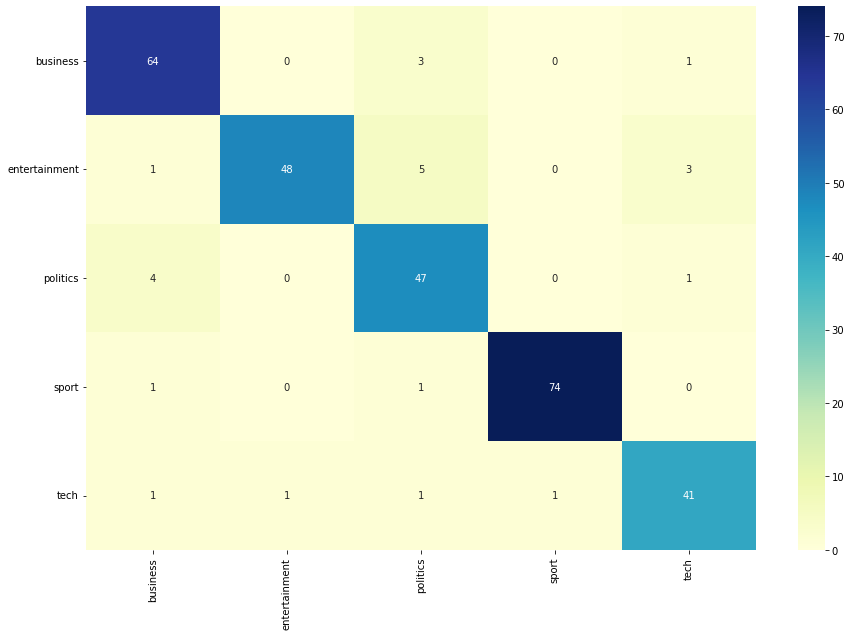

In [42]:
conf_matrix = confusion_matrix(test.Category, gnb_test_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_category_names, columns=test_category_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [43]:
print(classification_report(test.Category, gnb_test_predictions, target_names=test_category_names))

               precision    recall  f1-score   support

     business       0.90      0.94      0.92        68
entertainment       0.98      0.84      0.91        57
     politics       0.82      0.90      0.86        52
        sport       0.99      0.97      0.98        76
         tech       0.89      0.91      0.90        45

     accuracy                           0.92       298
    macro avg       0.92      0.91      0.91       298
 weighted avg       0.92      0.92      0.92       298



A simple vista el dato que más llama la atención es la baja precisión (0.82) a la hora de predecir la categoría 'politics'  ya que como podemos observar en la tabla califica de 'politics' varios textos que en realidad deberían ser etiquetados como 'entertainment', razón por la cual la exhaustividad/recall de 'entertainment' también es bastante baja con un valor de 0.84. Asimismo la precisión de 'business' es algo baja debido a los textos que confunde con 'politics', lo que hace que el recall de esta clase también disminuya.

Comparando con las predicciones anteriores observamos que no hay gran diferencia en cuanto al parámetro f1-score, lo que indica que este predictor es tan bueno como los anteriores.

Observamos que al igual que en los casos anteriores obtenemos los mejores valores para predecir la categoría 'sport' con un f1-score de 0.98 mientras los demás no pasan de 0.92. Que esto haya sucedido en la mayoría de clasificadores prácticamente nos confirma que esta categoría es la más 'fácil' de predecir ya que como hemos apuntado antes, probablemente sea la que más se diferencia de las demás.

### k-NN

In [44]:
knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(doc_embed_matrix_train, train.Category)

knn_train_predictions = knn_classifier.predict(doc_embed_matrix_train)
knn_test_predictions_2 = knn_classifier.predict(doc_embed_matrix_test)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train.Category))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions_2 == test.Category))

k-NN, porcentaje de aciertos en entrenamiento: 0.9731543624161074
k-NN, porcentaje de aciertos en test: 0.9328859060402684


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'business'),
  Text(1.5, 0, 'entertainment'),
  Text(2.5, 0, 'politics'),
  Text(3.5, 0, 'sport'),
  Text(4.5, 0, 'tech')])

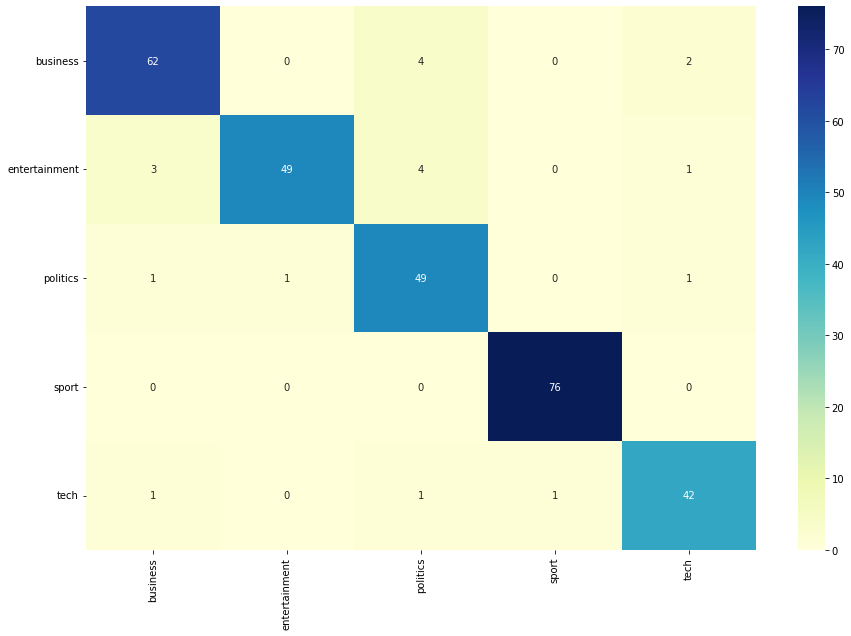

In [45]:
conf_matrix = confusion_matrix(test.Category, knn_test_predictions_2)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_category_names, columns=test_category_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [46]:
print(classification_report(test.Category, knn_test_predictions_2, target_names=test_category_names))

               precision    recall  f1-score   support

     business       0.93      0.91      0.92        68
entertainment       0.98      0.86      0.92        57
     politics       0.84      0.94      0.89        52
        sport       0.99      1.00      0.99        76
         tech       0.91      0.93      0.92        45

     accuracy                           0.93       298
    macro avg       0.93      0.93      0.93       298
 weighted avg       0.94      0.93      0.93       298



Para el k-NN obtenemos valores altos de precisión excepto para la categoría 'politics' para la cual es especialmente bajo ya que en este caso confunde estos textos con 'entertainment' y 'business'. En cuanto al recall, este mejora en todas las clases respecto de la vectorización anterior en el k-NN.

'Sport' vuelve a ser la cateogoría que mejor clasifica el modelo con bastante diferencia ya que da el mejor valor de f1-score con 0.99, teniendo una precisión de 0.99 y un recall de 1.00.

En general parece ligeramente mejor que cualquiera de los clasificadores anteriores si nos fijamos en los valores medios ponderados de las métricas.

## 4) Análisis comparativo final

Hemos entrenado dos clasificadores usando dos vectorizaciones diferentes de los datos. Compara la tasa de acierto de todos ellos y explica a qué crees que se deben las diferencias.

Busca un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias y otro mal clasificado por el k-NN con Word-embeddings. Analiza los vectores de términos de dichos mensajes e intenta razonar por qué ha sido clasificado erróneamente.

Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien y analiza las palabras más relevantes para clasificar una noticia como de dichas clases. Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.

----
Como ya hemos dicho antes los k-NN no deberian funcionar bien ya que debido al alto número de dimensiones buscar vecinos cercanos puede no funcionar correctamente. Esto se puede observar en el clasificador k-NN con la primera vectorización. Pensamos que la segunda vectorización debería funcionar mejor ya que hace uso de un mayor número de términos de los textos, lo que se traduce en más información útil. Sin embargo, con esta vectorización no se aprecia gran mejoría en los resultados, lo que se puede deber a un tamaño insuficiente del corpus que distorsione los resultados.

In [47]:
#Calculamos la posición de la primera predicción errónea del modelo
i = 0;
cat = np.array(test.Category)
while cat[i] == mnb_test_predictions[i]:
    i+=1
print(i)
print("Categoría real: ", cat[i])
print("Categorba predicha con Naive Bayes y vectorización de frecuencias: ", mnb_test_predictions[i])

18
Categoría real:  politics
Categorba predicha con Naive Bayes y vectorización de frecuencias:  business


In [48]:
write_terms(feature_names, np.array(test), test_vector_data, 18)

Mensaje 18 : job cuts  false economy   - tuc plans to shed 71 000 civil service jobs will prove to be a  false economy  that could hamper public sector reforms  according to a tuc report.  public and commercial services union members have already voted to strike over cuts for one day on 5 november. the tuc said cuts would deliver less than 6% of the £22bn ministers hope to save through efficiency reforms. general secretary brendan barber warned the  costs could easily outweigh the benefits .  the government s big boost to public spending is now showing results   said mr barber.  public services are improving but looking for simple savings through job cuts at this stage could be a false economy.   they may shoot a tory fox  but cutting thousands of civil service jobs will hit the morale and capabilities of the public servants expected to implement government reforms. the costs could easily outweigh the benefits.  next friday s strike action by the pcs is the biggest in the civil service

----
Antes de analizar el texto en cuestión debemos tener en cuenta que estos dos temas están estrechamente relacionados, pues una gran parte de la política trata las regulaciones económicas. Es por tanto entendible que estas dos categorñias se confundan y algunas de las palabras que han  podido llevar al modelo a elegir la categoría 'business' en lugar de 'politics' son _benefit_, _efficiency_, _commercial_, _jobs_ o _pay_. Asimismo también hay palabras que parecen más propias del campo de la política como _ministers_, _civil_, _social_, _voted_ o _government_. Cabe también destacar palabras que aparecen en el texto pero no en la vectorización y que podrían haber ayudado a decidirse por 'politics' como por ejemplo _economy_ y _public_.

In [49]:
#Calculamos la posición de una predicción errónea del modelo
i = 20;
while cat[i] == knn_test_predictions_2[i]:
    i+=1
print(i)
print("Categoría real: ", cat[i])
print("Categoría predicha con k-NN y word-embeddings: ", knn_test_predictions_2[i])

24
Categoría real:  tech
Categoría predicha con k-NN y word-embeddings:  business


In [50]:
write_terms(tokens, np.array(test), test_vector_m, 24)

Mensaje 24 : anti-spam laws bite spammer hard the net s self-declared spam king is seeking bankruptcy protection.  scott richter  the man behind optinrealbig.com and billions of junk mail messages  said lawsuits had forced the company into chapter 11. optinrealbig was fighting several legal battles  most notably against microsoft  which is pushing for millions of dollars in damages. the company said filing for chapter 11 would help it try to resolve its legal problems but still keep trading.  listed as the third biggest spammer in the world by junk mail watchdog spamhaus  optinrealbig was sued in december 2003 for sending mail messages that violated anti-spam laws. the lawsuit was brought by microsoft and new york attorney general eliot spitzer who alleged that mr richter and his accomplices sent billions of spam messages through 514 compromised net addresses in 35 countries. according to microsoft the messages were sent via net addresses owned by the kuwait ministries of communication

----
A priori no son dos categorías muy relacionadas, sin embargo en ciertas áreas sí que se puede encontrar una intersección entre estos dos temas. Un ejemplo de esto sería la prensa sobre la industria tecnológica, que de hecho es donde se podría enmarcar este texto. Algunas de las palabras que han podido llevar al clasificador a decidirse por la categoría 'business' en lugar de 'tech' son _dollars_, _company_, _business_, _bankruptcy_, _finance_ o _marketing_. Aun así hay muchas palabras que hacen pensar que este texto podría haber sido clasificado en 'tech' como _microsoft_, _com_, _net_, _watchdog_ o _spam_. A pesar de todas estas palabras es lógico que el clasificador haya podido confundirse entre estas dos categorías.

In [51]:
def print_top20_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print("Top 20 features per class\n")
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.feature_log_prob_[i])[-20:]
        reversed_top = top20[::-1]
        
        print("%s: %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')

In [52]:
vectorizer = CountVectorizer(vocabulary=dictionary, stop_words='english')   

In [53]:
print_top20_features_per_class_in_NB(vectorizer, mnb_classifier, test_category_names)

Top 20 features per class

business: said / firm / growth / oil / company / year / shares / sales / economic / profits / deal / prices / financial / government / business / chief / analysts / rates / companies / group 

entertainment: film / music / awards / band / said / award / album / films / year / festival / director / chart / number / actress / musical / nominated / comedy / including / movie / theatre 

politics: labour / said / election / party / government / minister / prime / tax / people / leader / plans / secretary / campaign / general / told / council / spokesman / says / local / police 

sport: game / said / cup / players / match / team / world / injury / final / play / year / coach / club / champion / half / second / open / arsenal / league / minutes 

tech: people / said / software / users / technology / phone / digital / music / computer / games / online / broadband / virus / search / video / phones / internet / million / mail / information 



----
Las clases que obtuvieron menos f1-score fueron 'tech' y 'entertainment', así que serán las que analizaremos. Cabe destacar, lo primero de todo, que la palabra _said_ aparece entre las más usadas para clasificar los textos en todas las categorías, lo cual es poco útil pues ante la aparición de esta palabra no se obtiene demasiada información para discriminar el tip de texto del que se trata. En cuanto a la clase 'tech', entre las palabras destacadas podemos encontrar _people_, _music_ o _search_, que son palabras muy comunes en el inglés y que pueden estar en otra categoría. Por ejemplo _music_ podría ser perfectamente una palabra muy usada en 'entertainment' y _people_ en 'politics', lo que podría llevar a clasificar textos de estas categorías como 'tech'. En cuanto a 'entertainment' podemos observar el mismo fenómeno con palabras como _year_, _chart_ y _number_ aunque sí que se aprecian términos más específicos del tema, lo que lleva a que tenga un mayor f1-score.

Por otro lado, lo que hace que una clase obtenga menor f1-score es que sus términos más específicos sean palabras que pueden aparecer con frecuencia también en otros ámbitos y por tanto en textos clasificados como de otras categorías. Esto ocurre más en las clases 'tech' y 'entertainment', y por eso tienen un valor más bajo en su f1-score. Ejemplos de esto pueden ser _information_, _internet_, _awards_ o _director_, que siendo específicos de su tema pueden aparecer en otros contextos.